In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import re
from matplotlib import pyplot as plt

In [2]:
df = pd.read_csv('data_hpo-method-validation_2023-02-28_10-35.csv', encoding="utf_16_le", delimiter=";")

# Goal - Methods

In [3]:
df_all=df.where((df['MAXPAGE']=='3')| (df['MAXPAGE']=='4') | (df['MAXPAGE']=='5') | (df['MAXPAGE']== 'Letzte Seite, die im Fragebogen bearbeitet wurde')).dropna(subset=['MAXPAGE']).copy()

In [4]:
df_all = df_all.replace('/Another HPO Method', '/Evolutionary Algorithm', regex=True)
df_all = df_all.replace('Model Comprehension', 'ML Model Understanding', regex=True)

In [5]:
# select only answers relating to the first question (Which of the following goals did you try to reach by using HPO?) 
df_go01=df_all.filter(regex=("^GO01"))

# select only answers relating to the second question (Which of the following goals did you successfully attain by using HPO?)
df_go02=df_all.filter(regex=("^GO02"))

## Number of Participants who have used a certain method

In [6]:
# create data frame summarizing all answers to the GD01 listing methods, goal, participant id and selection

goal_method = []
for index, column in enumerate(df_go01.columns):

    row = {}

    #extract the method
    item_description = df_go01[column][0]
    method = re.findall("([^/]+$)", item_description)[0]
    goal = re.findall(":\s(.*):", item_description)[0]
    value = df_go01[column].drop(0).apply(lambda x: 1 if x == 'ausgewählt' else 0)

    if index % 6 == 0:
        method = "I did not try to reach the goal"
        goal = re.search(":\s(.*):\s(.*):", item_description)
        goal = goal.group(2)
        value = df_go01[column].drop(0).apply(lambda x: 1 if x == r'I did not try to reach this goal.' else 0)

    for entry in value.items():
        row = {"method": method, "goal": goal, "participant": entry[0], "selection": entry[1]}
        goal_method.append(row)

df_goal_method = pd.DataFrame(goal_method)

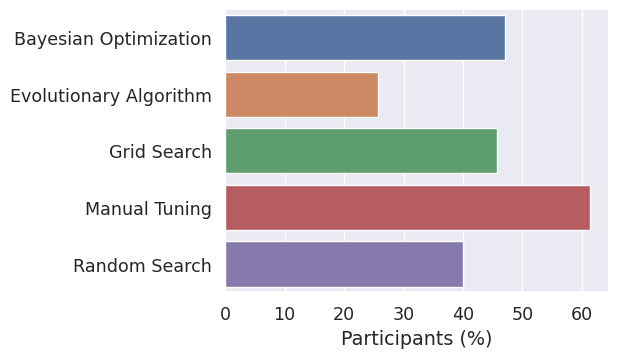

In [7]:
sns.set_theme()
sns.set(font_scale=1.15)

plt.figure(figsize=(6.4, 3.8))
seaborn_method_count=df_goal_method[df_goal_method['selection']==1].groupby('method')['participant'].nunique().drop('I did not try to reach the goal')
ax = sns.barplot((seaborn_method_count * 100 / df_goal_method['participant'].nunique()).reset_index(), x='participant',
                 y='method')
ax.set_ylabel(None)
ax.set_xlabel("Participants (%)")

plt.tight_layout()
plt.savefig('figs/participant_method_usage_percentage.pdf')
plt.show()

In [8]:
df_goal_method['participant'].nunique()

70

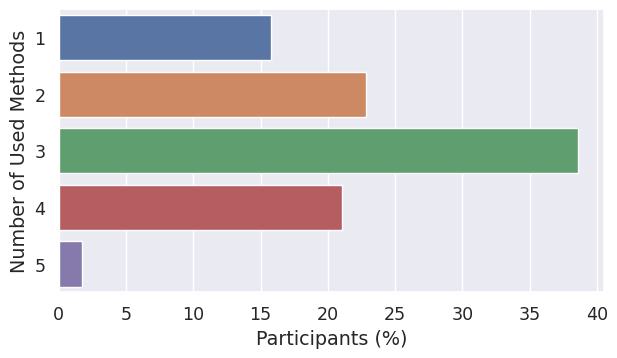

In [9]:
tmp = df_goal_method[
    (df_goal_method['selection'] == 1) & (df_goal_method['method'] != 'I did not try to reach the goal')].groupby(
    ['participant', 'method']).nunique().reset_index()[['participant', 'method']]
tmp = tmp.groupby('participant').count().value_counts().reset_index()
tmp['participants'] = tmp['count'] * 100 / tmp['count'].sum()

plt.figure(figsize=(6.4, 3.8))
ax = sns.barplot(tmp, x='participants', y='method', orient='h')
ax.set_xlabel("Participants (%)")
ax.set_ylabel("Number of Used Methods")

plt.tight_layout()
plt.savefig('figs/multiple_hpo_methods.pdf')
plt.show()

## Pursued Goals

In [10]:
# define method to create heatmap counting all occurences of method combinations

def create_2d_matrix(df):
  heatmap = []

  for index, column in enumerate(df.columns):
    #extract the method
    item_description = df[column][0]
    method = re.findall("([^/]+$)", item_description)[0]
    goal = re.findall(":\s(.*):", item_description)[0]

    count = df[column].str.contains(r'ausgewählt').sum()


    if index%6 == 0:
      method = "I did not try to reach the goal"
      goal = re.search(":\s(.*):\s(.*):", item_description)
      goal = goal.group(2)
      count = df[column].str.contains(r'I did not try to reach this goal.').sum()


    row={"method": method, "goal": goal, "count": count}


    heatmap.append(row)

  df_heatmap = pd.DataFrame(heatmap)


  return df_heatmap.pivot(index='method', columns='goal', values='count')


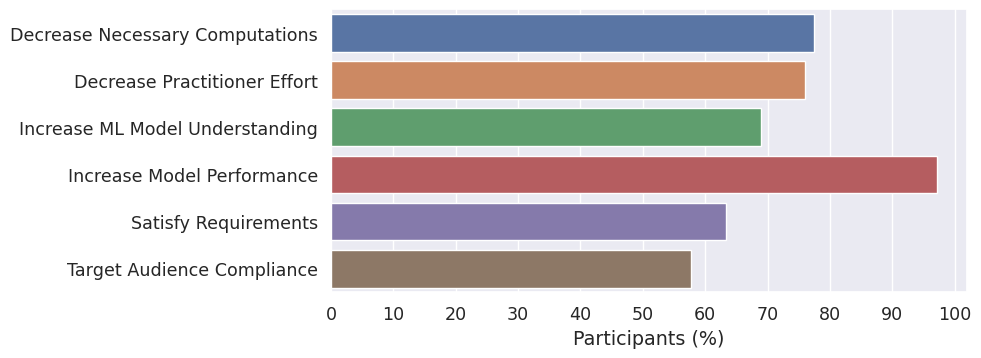

In [11]:
pursued_goals = create_2d_matrix(df_go01)

pursued_goals = (1 - pursued_goals.loc['I did not try to reach the goal'] / df_go01.shape[0]).reset_index()
pursued_goals['I did not try to reach the goal'] = pursued_goals['I did not try to reach the goal'] * 100

plt.figure(figsize=(10, 3.8))
ax = sns.barplot(pursued_goals, x='I did not try to reach the goal', y='goal')
ax.set_xlabel("Participants (%)")
ax.set_ylabel(None)
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100])

plt.tight_layout()
plt.savefig('figs/pursued_goals.pdf')
plt.show()

In [12]:
pursued_goals

,goal,I did not try to reach the goal
0,Decrease Necessary Computations,77.464789
1,Decrease Practitioner Effort,76.056338
2,Increase ML Model Understanding,69.014085
3,Increase Model Performance,97.183099
4,Satisfy Requirements,63.380282
5,Target Audience Compliance,57.746479


## Goal Method Heatmap

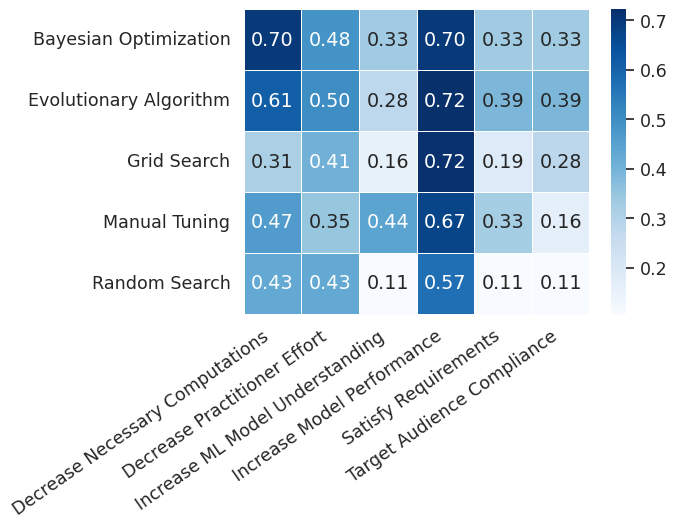

In [13]:
hm = create_2d_matrix(df_go01).drop(index='I did not try to reach the goal').divide(seaborn_method_count, axis='rows')

plt.figure(figsize=(7, 5.5))
ax = sns.heatmap(hm, annot=True, cmap='Blues', linewidth=.5, fmt='.2f')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xticks(rotation=35, ha='right')

plt.tight_layout()
plt.savefig('figs/attempted_goal_method_matrix.pdf')
plt.show()

### Correcting survey tool

In [14]:
tried=df_go01.where(df_go01=="ausgewählt").replace({'ausgewählt': 1})
tried=tried.fillna(0)

success=df_go02.where(df_go02=="ausgewählt").replace({'ausgewählt': 1})
success=success.fillna(0)

res = success[success>tried.values].dropna(how='all')

/tmp/ipykernel_39751/1150121345.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  tried=df_go01.where(df_go01=="ausgewählt").replace({'ausgewählt': 1})
/tmp/ipykernel_39751/1150121345.py:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  success=df_go02.where(df_go02=="ausgewählt").replace({'ausgewählt': 1})


In [15]:
cell_locations = []
for i in range(len(res)):
  for j in range(len(res.columns)):
    if res.iloc[i, j] == 1:
      cell_locations.append((res.index[i], res.columns[j]))

In [16]:
for location in cell_locations:
  df_go02.at[location[0], location[1]] = 'nicht gewählt'

<Axes: xlabel='goal', ylabel='method'>

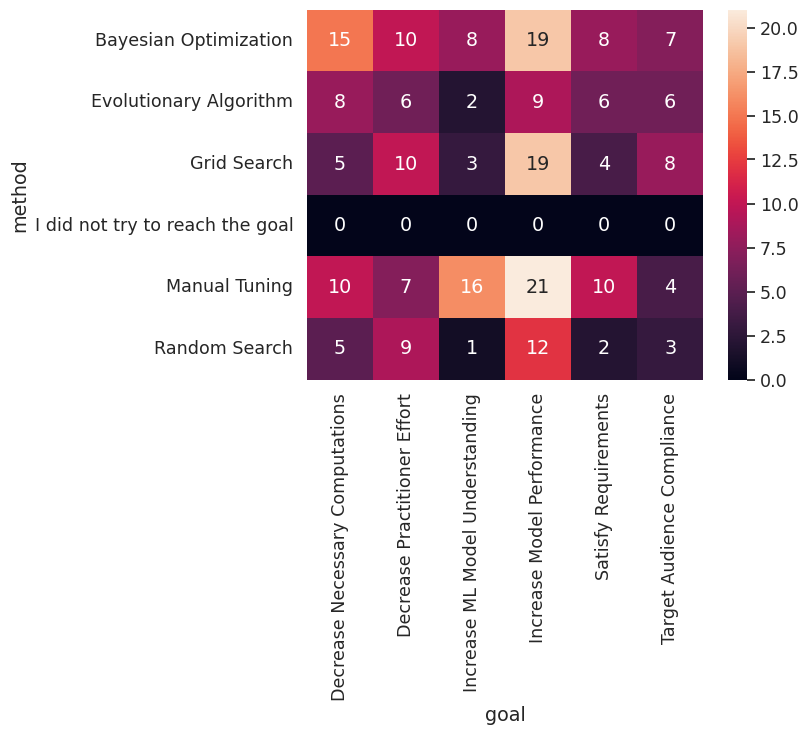

In [17]:
sns.heatmap(create_2d_matrix(df_go02), annot=True)

## Self Reported Successrate

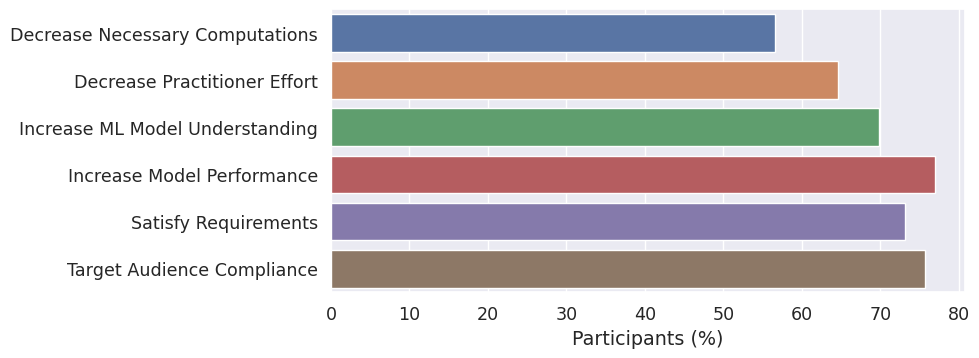

In [18]:
count = create_2d_matrix(df_go01).drop(index='I did not try to reach the goal')
weights = count / count.sum()

success = create_2d_matrix(df_go02).drop('I did not try to reach the goal')
(success / count).sum().reset_index()
tmp = (success / count * weights).sum().reset_index()
tmp[0] *= 100

plt.figure(figsize=(10, 3.8))
ax = sns.barplot(tmp, x=0, y='goal')
ax.set_ylabel(None)
ax.set_xlabel("Participants (%)")

plt.tight_layout()
plt.savefig('figs/sucess_rate_per_goal.pdf')
plt.show()


In [19]:
(success / count * weights).sum().reset_index()

,goal,0
0,Decrease Necessary Computations,0.565789
1,Decrease Practitioner Effort,0.646154
2,Increase ML Model Understanding,0.697674
3,Increase Model Performance,0.769231
4,Satisfy Requirements,0.731707
5,Target Audience Compliance,0.756757


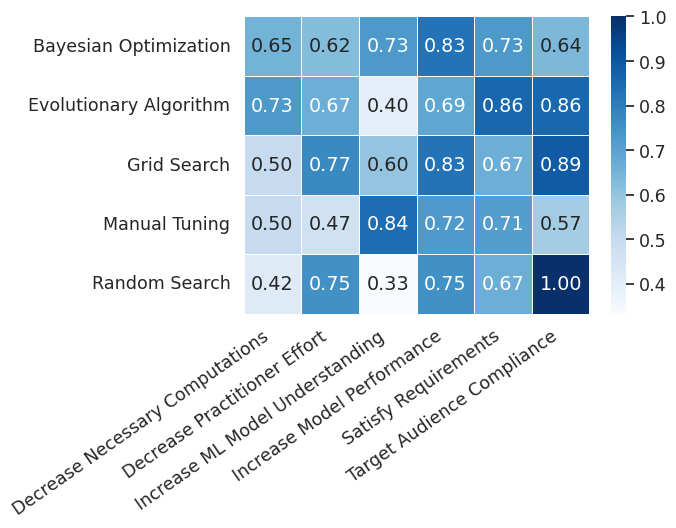

In [20]:
plt.figure(figsize=(7, 5.5))
ax = sns.heatmap((create_2d_matrix(df_go02)/create_2d_matrix(df_go01)).drop('I did not try to reach the goal'), annot=True, cmap='Blues', linewidth=.5, fmt='.2f')
ax.set_xlabel(None)
ax.set_ylabel(None)
plt.xticks(rotation=35, ha='right')

plt.tight_layout()
plt.savefig('figs/self_reported_success_rate_heatmap.pdf')
plt.show()


# Decision Factors

In [21]:
map = {'I did not consider this decision factor.': np.NaN ,'Very Low': -2, 'Low': -1, 'Neutral': 0, 'High': 1, 'Very High': 2}

In [22]:
df_decision_factors=df.where((df['MAXPAGE']=='4') | (df['MAXPAGE']=='5') | (df['MAXPAGE']== 'Letzte Seite, die im Fragebogen bearbeitet wurde')).dropna(subset=['MAXPAGE']).replace(map)

In [23]:
rows=[]
for i in range(1,25):

  entry={}  

  for j in range(1,15):
    goal_method_df = df_decision_factors.filter(regex=(f"^GD{i:02d}")).dropna(how='all')

    #Handle empty dataframe
    try:
      description_string = goal_method_df.filter(regex=(f"_{j:02d}")).iloc[0,:].values[0]
    except:
      continue  


    factor_df = goal_method_df.drop(0).filter(regex=(f"_{j:02d}"))
    participant_array = factor_df.index
    value_array = factor_df.values

    question = re.findall("([^/]+):", description_string)[0]
    decision_factor = re.findall(": ([^/]+) \(\(", description_string)[0]

    if decision_factor == 'Model Comprehension':
        decision_factor = 'ML Model Comprehension'

    for index, value in enumerate(value_array):
    
      #entry={'Question': question, 'Decision Factor': decision_factor, "Value": float(value), "Participant": int(participant_array[index])}
      entry={'Question': question, 'Decision Factor': decision_factor, "Value": value[0], "Participant": int(participant_array[index])}
      rows.append(entry)

decision_factor_results = pd.DataFrame(rows)
decision_factor_results.loc[decision_factor_results['Decision Factor'] == 'HP search space size', 'Decision Factor'] = 'Search Space Size'

In [24]:
#dropping answers labeled "nicht beantwortet"
decision_factor_results = decision_factor_results.drop(decision_factor_results[decision_factor_results['Value']=='nicht beantwortet'].index)
decision_factor_results['Value'] = pd.to_numeric(decision_factor_results['Value'])

## Percentage I did consider this decision factor

In [25]:
nan_decision=decision_factor_results.groupby('Decision Factor')['Value'].apply(lambda _df: _df.isna().sum())
count_decision=decision_factor_results.groupby('Decision Factor')['Value'].count()
combined=count_decision.add(nan_decision)
percentag_nan=(nan_decision/combined).reset_index()

percentag_nan['Value'] = (1 - percentag_nan['Value']) * 100
percentag_nan.sort_values('Value')

percentag_nan

,Decision Factor,Value
0,Acceptance of Advanced Methods,62.837838
1,Available Compute Resources,82.432432
2,Cost of Objective Function,78.378378
3,HPO Method Comprehension,83.783784
4,HPO Method Traceability,79.054054
5,HPO setup readiness,90.540541
6,Literature,77.027027
7,ML Model Comprehension,83.108108
8,Parallization Possibilities,69.594595
9,Personal Experience,92.567568


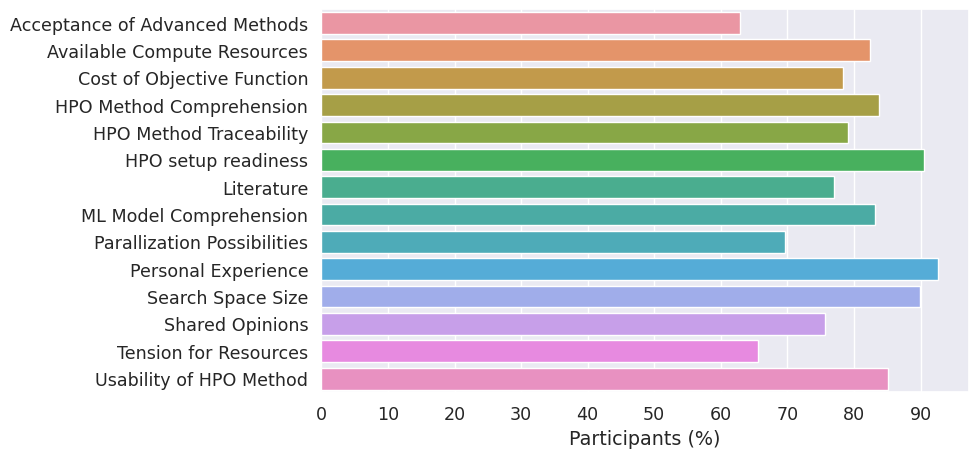

In [26]:
plt.figure(figsize=(10, 4.8))
ax = sns.barplot(percentag_nan, x='Value', y='Decision Factor')
ax.set_ylabel(None)
ax.set_xlabel("Participants (%)")
ax.set_xticks([0, 10, 20, 30, 40, 50, 60, 70, 80, 90])

plt.tight_layout()
plt.savefig('figs/i_did_consider_decision_factor_percentage.pdf')
plt.show()

## Average Importance

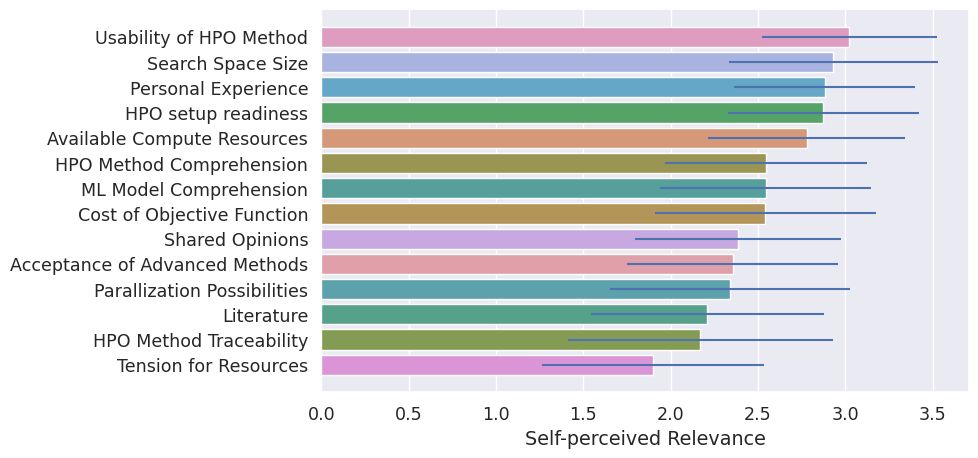

In [27]:
#decision_factor_results.groupby(["Decision Factor"]).mean().sort_values('Value')['Value'].plot(kind='bar')
tmp = decision_factor_results[['Decision Factor', 'Value']].groupby(["Decision Factor"]).mean()['Value'].reset_index()
tmp['error'] = decision_factor_results[['Decision Factor', 'Value']].groupby(["Decision Factor"]).std().reset_index()['Value']
tmp['Value'] += 2
tmp['colors'] = [(0.9161184715926312, 0.587423760636183, 0.6402637703546576), (0.8937660835489727, 0.5787697184671898, 0.41495599669770367), (0.7619323438618786, 0.602524817229626, 0.2923912886416704), (0.6495335092730091, 0.6223042533576598, 0.27554181266411526), (0.5319772995700917, 0.6539328673390671, 0.2754196015145106), (0.2820981586808853, 0.690353333562012, 0.370567146847935), (0.28938836863285256, 0.6789788565569387, 0.5612449573484168), (0.29392978066022357, 0.6712452658853462, 0.6438342685860048), (0.3071080186559755, 0.671626456963976, 0.723521305871116), (0.3333312855792858, 0.6761594472536527, 0.8420954243785803), (0.6268852145988868, 0.6777677918604348, 0.916300649166299), (0.7816585606524555, 0.6241265214830457, 0.9156622898151093), (0.9040999261209899, 0.540448897448067, 0.8801077671623444), (0.9112471953329075, 0.5686857066638114, 0.7569922200807973)]
tmp2 = tmp.sort_values(by='Value', ascending=False)

plt.figure(figsize=(10, 4.8))
ax = sns.barplot(tmp2, x='Value', y='Decision Factor', palette=tmp2['colors'])
ax.errorbar(x=tmp2["Value"], y=range(0, 14), xerr=tmp2["error"] / 2, fmt="none")
ax.set_ylabel(None)
ax.set_xlabel("Self-perceived Relevance")
#ax.set_xticks([-1, 0, 1])
#ax.set_xticklabels(['Low', 'Neutral', 'High'])

plt.tight_layout()
plt.savefig('figs/average_importance_decision_factors.pdf')
plt.show()

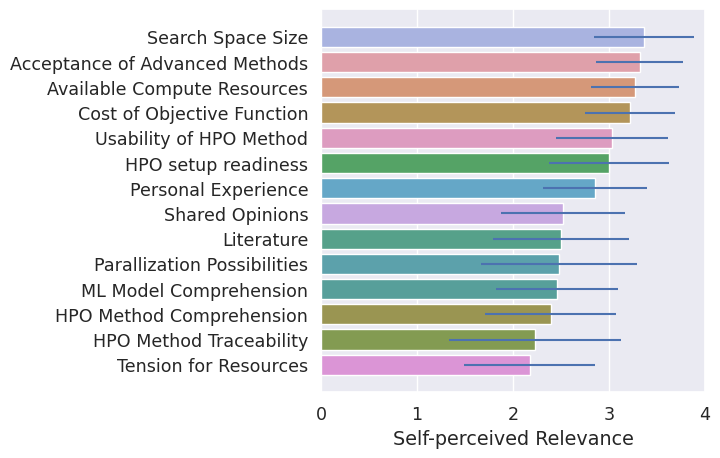

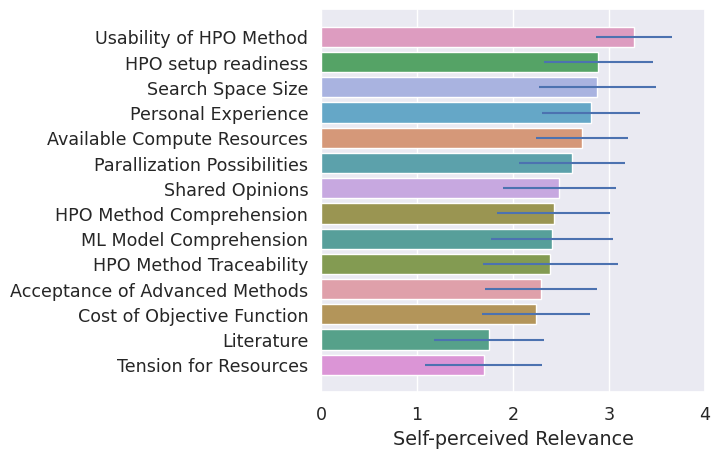

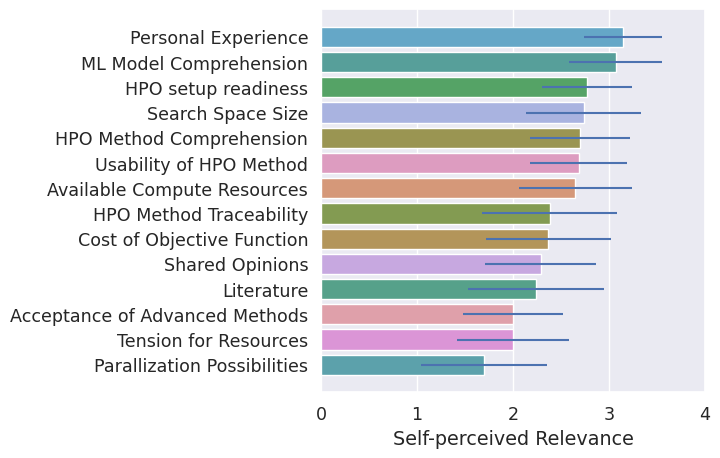

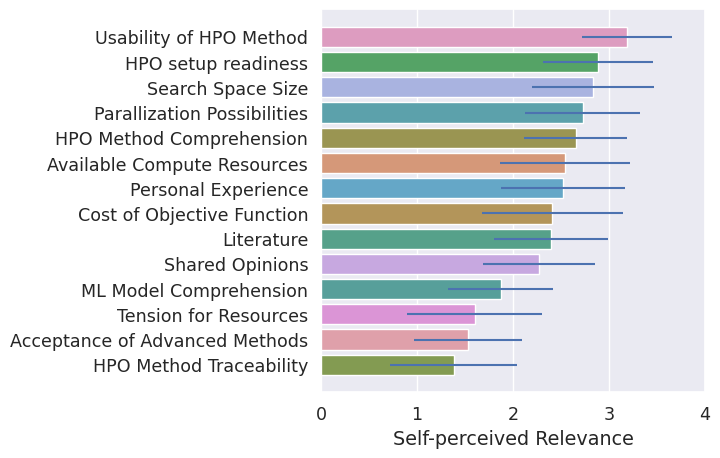

In [28]:
tmp_ = decision_factor_results
tmp_['Question'] = decision_factor_results['Question'].str[:2]

tmp = tmp_.groupby(['Question', 'Decision Factor']).mean(['Value']).reset_index()
tmp['Value'] += 2
tmp['error'] = tmp_.groupby(['Question', 'Decision Factor']).std().reset_index()['Value']

for hpo in tmp['Question'].unique():
    plt.figure(figsize=(7.5, 4.8))

    tmp2 = tmp[tmp['Question'] == hpo][['Value', 'Decision Factor', 'error']]
    tmp2['colors'] = [(0.9161184715926312, 0.587423760636183, 0.6402637703546576), (0.8937660835489727, 0.5787697184671898, 0.41495599669770367), (0.7619323438618786, 0.602524817229626, 0.2923912886416704), (0.6495335092730091, 0.6223042533576598, 0.27554181266411526), (0.5319772995700917, 0.6539328673390671, 0.2754196015145106), (0.2820981586808853, 0.690353333562012, 0.370567146847935), (0.28938836863285256, 0.6789788565569387, 0.5612449573484168), (0.29392978066022357, 0.6712452658853462, 0.6438342685860048), (0.3071080186559755, 0.671626456963976, 0.723521305871116), (0.3333312855792858, 0.6761594472536527, 0.8420954243785803), (0.6268852145988868, 0.6777677918604348, 0.916300649166299), (0.7816585606524555, 0.6241265214830457, 0.9156622898151093), (0.9040999261209899, 0.540448897448067, 0.8801077671623444), (0.9112471953329075, 0.5686857066638114, 0.7569922200807973)]
    tmp2 = tmp2.sort_values(by='Value', ascending=False)

    ax = sns.barplot(tmp2, x='Value', y='Decision Factor', palette=tmp2['colors'])
    ax.errorbar(x=tmp2["Value"], y=range(0, 14), xerr=tmp2["error"] / 2, fmt="none")
    ax.set(xlim=(0, 4))


    ax.set_ylabel(None)
    ax.set_xlabel("Self-perceived Relevance")

    plt.tight_layout()
    plt.savefig(f'figs/average_importance_decision_factors_{hpo}.pdf')
    plt.show()



In [29]:
from seaborn import utils

sns.color_palette(utils.get_color_cycle(), n_colors=14, desat=0.75)

[(0.34705882352941175, 0.4588235294117645, 0.6411764705882353),
 (0.7985294117647057, 0.536764705882353, 0.38970588235294135),
 (0.37401960784313726, 0.6181372549019608, 0.42990196078431375),
 (0.7107843137254902, 0.3637254901960786, 0.3754901960784314),
 (0.5230392156862746, 0.47892156862745106, 0.6700980392156861),
 (0.5514705882352942, 0.47205882352941175, 0.401470588235294),
 (0.8161764705882354, 0.5838235294117645, 0.7485294117647059),
 (0.5490196078431373, 0.5490196078431373, 0.5490196078431373),
 (0.7568627450980392, 0.7009803921568627, 0.4980392156862745),
 (0.44362745098039214, 0.6818627450980392, 0.7524509803921569),
 (0.34705882352941175, 0.4588235294117645, 0.6411764705882353),
 (0.7985294117647057, 0.536764705882353, 0.38970588235294135),
 (0.37401960784313726, 0.6181372549019608, 0.42990196078431375),
 (0.7107843137254902, 0.3637254901960786, 0.3754901960784314)]

In [30]:
decision_factor_results.groupby(["Decision Factor"]).mean().nlargest(3,'Value')

TypeError: agg function failed [how->mean,dtype->object]

In [ ]:
decision_factor_results.groupby(["Decision Factor"]).mean().nsmallest(3,'Value')

### Per participant

In [ ]:
decision_factor_results.groupby(['Participant']).mean().plot(kind='bar')

### Manual Tuning

In [ ]:
mt_decision_factors=decision_factor_results[decision_factor_results.Question.str.startswith('MT')]
mt_df = mt_decision_factors.groupby(["Decision Factor"]).mean()

In [ ]:
mt_df['Value'].plot(kind='bar')

In [ ]:
mt_df.nlargest(3,'Value')

In [ ]:
mt_df.sort_values('Value')

In [ ]:
mt_df.nsmallest(3,'Value')

### Bayesian Optimization

In [ ]:
bo_decision_factors=decision_factor_results[decision_factor_results.Question.str.startswith('BO')]
bo_df = bo_decision_factors.groupby(["Decision Factor"]).mean()

In [ ]:
bo_df['Value'].plot(kind='bar')

In [ ]:
bo_df.nlargest(3,'Value')

In [ ]:
bo_df.nsmallest(3,'Value')

### Grid Search

In [ ]:
gs_decision_factors=decision_factor_results[decision_factor_results.Question.str.startswith('GS')]
gs_df = gs_decision_factors.groupby(["Decision Factor"]).mean()

In [ ]:
gs_df['Value'].plot(kind='bar')

In [ ]:
gs_df.nlargest(3,'Value')

In [ ]:
gs_df.nsmallest(3,'Value')

### Random Search

In [ ]:
rs_decision_factors=decision_factor_results[decision_factor_results.Question.str.startswith('RS')]
rs_df = rs_decision_factors.groupby(["Decision Factor"]).mean()

In [ ]:
rs_df['Value'].plot(kind='bar')

In [ ]:
rs_df.nlargest(3,'Value')

In [ ]:
rs_df.nsmallest(3,'Value')

# Demographics

Hier haben wir natürlich die wenigsten Daten. Wenn wir vorher immer ein größeres n benutzen kann man das natürlich nicht so gut angeben

In [ ]:
df_finished = df.where((df["FINISHED"] == "1")  | (df["FINISHED" ]== "Wurde die Befragung abgeschlossen (letzte Seite erreicht)?")).dropna(subset=["FINISHED"])

In [ ]:
for i in range(2, 10):
  print(df_finished.filter(regex=(f"^DE{i:02d}")).value_counts())

In [ ]:
df_finished.filter(regex=(f"^DE"))

In [ ]:
df_finished[f"DE03"].value_counts()

In [ ]:
df_finished['DE01_05a'].value_counts()